In [53]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from scipy.stats.mstats import winsorize

In [54]:
# ===================================================================
# Chargement des données brutes
# ======================================================================
DATA_PATH = Path("/home/sacko/Documents/SEGMENTATION_ECOMERCE/Donnees/olist_dataset.csv")

DATE_COLS = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_customer_date"
]

def load_olist_master(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    for col in DATE_COLS:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce")
    return df

In [55]:
# ========================================================
# Préparation des données pour la segmentation
# ==========================================================

def prepare_base_for_segmentation(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    if "order_status" in df.columns:
        df = df[df["order_status"] == "delivered"]

    df = df.drop_duplicates(subset=["order_id", "customer_unique_id"])
    df = df.dropna(subset=["customer_unique_id", "order_purchase_timestamp", "payment_value"])

    return df

In [56]:
# ==============================================
# Prétraitement spécifique de variable monétaires 
# =====================================================
def preprocess_monetary_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = df[df["payment_value"] >= 0]

    df["payment_value_wins"] = winsorize(df["payment_value"], limits=[0, 0.01])
    df["payment_value_log"] = np.log1p(df["payment_value_wins"])

    return df

In [57]:
# ======================================================
# table de calcul RFM
# ===========================================================
def compute_rfm_table(df: pd.DataFrame) -> pd.DataFrame:
    max_ts = df["order_purchase_timestamp"].max()
    NOW = max_ts + pd.Timedelta(days=1)

    return (
        df.groupby("customer_unique_id")
        .agg(
            recency=("order_purchase_timestamp", lambda x: (NOW - x.max()).days),
            frequency=("order_id", "nunique"),
            monetary_value=("payment_value", "sum")
        )
    )

In [58]:
# =========================================================
# Préparation des variables RFM
# ======================================================
def prepare_rfm_features(rfm: pd.DataFrame):
    scaler = StandardScaler()
    return scaler.fit_transform(rfm[["recency", "frequency", "monetary_value"]])

In [59]:
# ======================================================
# Ajustement K-means
# ======================================================
def fit_kmeans(X, n_clusters=4):
    model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = model.fit_predict(X)
    return model, labels

In [60]:
# =======================================================
# Surveillance de la stabilité de k-means
# ======================================================
def monitor_kmeans_stability(
    df_transactions: pd.DataFrame,
    step_days: int = 7,
    window_days: int = 365,
    n_clusters: int = 4
):
    max_date = df_transactions["order_purchase_timestamp"].max()
    ref_cutoff = max_date - pd.Timedelta(days=window_days)

    df_ref = df_transactions[df_transactions["order_purchase_timestamp"] <= ref_cutoff]

    rfm_ref = compute_rfm_table(df_ref)
    X_ref = prepare_rfm_features(rfm_ref)
    _, labels_ref = fit_kmeans(X_ref, n_clusters)

    ari_scores, days = [], []

    for i in range(0, window_days, step_days):
        df_temp = df_transactions[
            df_transactions["order_purchase_timestamp"] <= ref_cutoff + pd.Timedelta(days=i)
        ]

        rfm_temp = compute_rfm_table(df_temp)
        X_temp = prepare_rfm_features(rfm_temp)
        _, labels_temp = fit_kmeans(X_temp, n_clusters)

        common_ids = rfm_ref.index.intersection(rfm_temp.index)

        ari = adjusted_rand_score(
            labels_ref[rfm_ref.index.get_indexer(common_ids)],
            labels_temp[rfm_temp.index.get_indexer(common_ids)]
        )

        ari_scores.append(ari)
        days.append(i)

    return days, ari_scores

In [61]:
# ========================================================
# Progression de la zone de l'intrigue
# =======================================================
def plot_ari_progression(days, ari_scores):
    plt.figure(figsize=(12,6))
    plt.plot(days, ari_scores, color="red", linewidth=2)
    plt.axhline(0.30, linestyle="--", color="orange", label="Surveillance")
    plt.axhline(0.20, linestyle="--", color="darkred", label="Critique")
    plt.legend()
    plt.title("Stabilité des clusters K-Means (ARI)")
    plt.xlabel("Jours")
    plt.ylabel("ARI")
    plt.grid(True)
    plt.show()

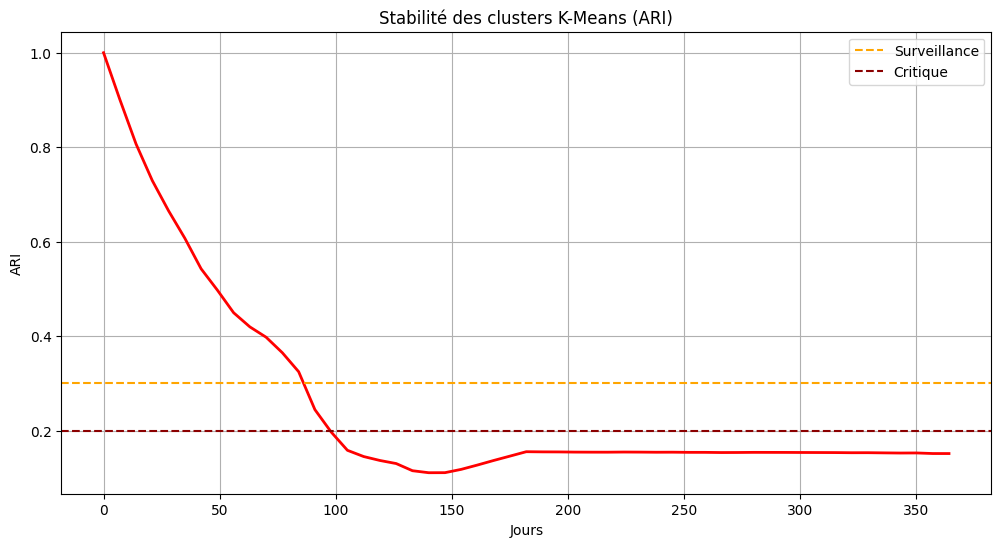

In [62]:
if __name__ == "__main__":
    df_raw = load_olist_master(DATA_PATH)
    df_clean = prepare_base_for_segmentation(df_raw)
    df_clean = preprocess_monetary_features(df_clean)

    days, ari_scores = monitor_kmeans_stability(df_clean)
    plot_ari_progression(days, ari_scores)